# Utilities

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from jupyterthemes import jtplot
import matplotlib as mpl
import scipy.stats as st
import pandas as pd
from scipy import stats
import cartopy.crs as ccrs
import cartopy
import xarray as xr
from shapely.geometry.polygon import LinearRing
from EWS_functions import *
from scipy.optimize import curve_fit
from scipy.ndimage import gaussian_filter1d
import statsmodels.api as sm
import scipy.stats as st

mpl.rcdefaults() 

jtplot.style(context='paper', fscale=1.4, spines=True, grid=False, ticks=True,gridlines='--')

fontsize=16
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['xtick.top'] = True
mpl.rcParams['ytick.right'] = True

mpl.rcParams['font.size'] = 16
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['figure.titlesize'] = 'medium'
mpl.rcParams['axes.labelsize']= 'x-large'
mpl.rcParams['figure.facecolor']='white'


mpl.rcParams['text.latex.preamble']= r'\usepackage{amsmath}'


mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=['#1b9e77','#d95f02','#7570b3','#e7298a','#66a61e','#e6ab02','#a6761d','#666666']) 

In [7]:
def yearly_avg(data):
    month_length = data.time.dt.days_in_month
    wgts = month_length.groupby("time.year") / month_length.groupby("time.year").sum()
    
    cond = data.isnull().groupby("time.year").sum()
    ones = xr.where(cond, np.nan, 1.0)
    
    avg = (data*wgts).groupby("time.year").sum()*ones
    
    return avg

In [8]:
labels = ['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z']
labels2 = ['(a)','(b)','(c)','(d)','(e)','(f)','(g)','(h)','(i)','(j)']

In [9]:
def runmean(x, w):

    n = x.shape[0]
    xs = np.zeros_like(x)
    for i in range(w // 2):
        xs[i] = np.nanmean(x[: i + w // 2 + 1])
    for i in range(n - w // 2, n):
        xs[i] = np.nanmean(x[i - w // 2 + 1:])

    for i in range(w // 2, n - w // 2):
        xs[i] = np.nanmean(x[i - w // 2 : i + w // 2 + 1])
    return xs

def lambda_wrapper_rmean(amoc,ws=50,rws=50):
    if np.count_nonzero(np.isnan(amoc))==0:
        try:
            amoc = np.nan_to_num(amoc)
            amoc_low = runmean(amoc, rws)
            if amoc.sum() != 0:
                lamb = run_fit_a_ar1((amoc-amoc_low),ws)
            else:
                lamb = np.full(len(amoc),np.nan)
        except:
            print('failed to get lambda')
            print(amoc-amoc_low)
            lamb = np.full(len(amoc),np.nan)
    else:
        lamb = np.full(len(amoc),np.nan)
    return lamb


In [10]:
def f(x):
    if not np.isnan(x[-1]):
        x=x[~np.isnan(x)]
        return st.percentileofscore(x, x[-1])
    else:
        return np.nan

def get_significance(mean_trend, surr_trend,edim='smps',mdims=['lat','lon'],level=0.05,axis=0):
    d = mean_trend.expand_dims(dim=edim, axis=0)
    d[edim]=[int(len(surr_trend[edim].values))]
    trend_arr = xr.concat((surr_trend,d),dim=edim)
    trend_pvs = 1- np.apply_along_axis(f, axis, trend_arr)/100
    try:
        pv_array = xr.Dataset(
                data_vars = dict(pv=(mdims,trend_pvs)),
                coords = dict(
                        lat = d.lat,
                lon = d.lon))
    except:
        pv_array = xr.Dataset(
        data_vars = dict(pv=(mdims,trend_pvs)),
        coords = dict(
                latitude = d.latitude,
        longitude = d.longitude))
    return pv_array.pv.where(pv_array.pv<=level)


In [11]:
def get_pvs(mean_trends,surr_trends,edim='surrogates',mdims=['smps','member'],axis=2):
    d = mean_trends.expand_dims(dim=edim, axis=0)
    d[edim]=[len(surr_trends[edim])]
    trend_arr = xr.concat((surr_trends,d),dim=edim)
    trend_pvs = 1- np.apply_along_axis(f, axis, trend_arr)/100
    pv_array = (mean_trends.copy(data=trend_pvs)).to_dataset(name='pv')
    return pv_array

# Indices

## HadSST data

In [52]:
amocsy = xr.open_dataset('/p/tmp/mayayami/sst-uncertainties-data/uncertainties/ensemble_members/sampled/sampled_HadSST.4.0.1.0_ensemble_member_all_amoc_ymeancon.nc').samples[:,:-1]
amoc = xr.open_dataset('/p/tmp/mayayami/sst-uncertainties-data/HadSST/HadSST.4.0.1.0_median_amoc.nc').tos.squeeze()[:-2]
amocy = yearly_avg(amoc)

In [53]:
smpl_surr_trends = xr.open_dataset('/p/tmp/mayayami/sst-uncertainties-data/uncertainties/ensemble_members/sampled/to_merge/sampled_HadSST.4.0.1.0_ensemble_member_all_amoc_fsurrogates_dt50_lams_w60_ndt_trends.nc').lams_polyfit_coefficients.sel(degree=1)
amc_lam = lambda_wrapper_rmean(amocy.values[23:],ws=60)
amc_lambdas = xr.open_dataset('/p/tmp/mayayami/sst-uncertainties-data/uncertainties/ensemble_members/sampled/sampled_HadSST.4.0.1.0_ensemble_member_all_amoc_lambdas_w60_runmean.nc').lams
trends = xr.open_dataset('/p/tmp/mayayami/sst-uncertainties-data/uncertainties/ensemble_members/sampled/sampled_HadSST.4.0.1.0_ensemble_member_all_amoc_lambdas_w60_runmean_trends.nc').polyfit_coefficients.sel(degree=1)
ttrend = st.linregress(np.arange(amc_lam[30:-30].shape[0]), amc_lam[30:-30])[0]
pv_array=get_pvs(trends,smpl_surr_trends)

In [54]:
mean_surr_trends= xr.open_dataset('/p/tmp/mayayami/sst-uncertainties-data/HadSST/lams/HadSST.4.0.1.0_median_amoc_fsurrogates_dt50_lambdas_w60_rmean_trends.nc').lams_polyfit_coefficients.sel(degree=1)
data = mean_surr_trends.values.ravel()
data = data[~np.isnan(data)]
pv = 1-st.percentileofscore(data, ttrend)/100

## HadCRUT data

In [55]:
Camocy = xr.open_dataset('/p/tmp/mayayami/sst-uncertainties-data/HadCRUT/HadCRUT.5.0.1.0.analysis.anomalies.ensemble_mean_SST_amoc_ymeancon.nc').tas_mean.squeeze()[:-1]

In [56]:
mem_surr_trends = xr.open_dataset('/p/tmp/mayayami/sst-uncertainties-data/HadCRUT/HadCRUT_members_SST_fsurrogates_dt50_amoc_full_lams_w60_ndt_trends.nc').lams_polyfit_coefficients.sel(degree=1)

Camocsy = xr.open_dataset('/p/tmp/mayayami/sst-uncertainties-data/HadCRUT/HadCRUT.5.0.1.0.analysis.anomalies_full_SST_amoc_ymeancon.nc').squeeze().tas

Clams = xr.open_dataset('/p/tmp/mayayami/sst-uncertainties-data/HadCRUT/HadCRUT.5.0.1.0.analysis.anomalies_full_SST_amoc_lams_w60_runmean.nc').lams
Clam = lambda_wrapper_rmean(Camocy,ws=60)

Ctrends=xr.open_dataset('/p/tmp/mayayami/sst-uncertainties-data/HadCRUT/HadCRUT.5.0.1.0.analysis.anomalies_full_SST_amoc_lams_w60_runmean_trends.nc').lams_polyfit_coefficients.sel(degree=1)
Cttrend = st.linregress(np.arange(Clam[30:-30].shape[0]), Clam[30:-30])[0]

Cpv_array = get_pvs(Ctrends,mem_surr_trends,mdims=['member'],axis=1)

In [57]:
Cmean_surr_trends = xr.open_dataset('/p/tmp/mayayami/sst-uncertainties-data/HadCRUT/HadCRUT.5.0.1.0.analysis.anomalies_median_SST_amoc_fsurrogates_dt50_lams_w60_ndt_trends.nc').lams_polyfit_coefficients.sel(degree=1)
data = Cmean_surr_trends.values.ravel()
data = data[~np.isnan(data)]
Cpv = 1-st.percentileofscore(data, Cttrend)/100

## ERSST data

In [58]:
Eamocsy = xr.open_dataset('/p/tmp/mayayami/sst-uncertainties-data/ERSSTv5/sst2d.ano.1854.2017.ensemble_amoc_full_ymean.nc').sst
Eamocy = xr.open_dataset('/p/tmp/mayayami/sst-uncertainties-data/ERSSTv5/sst.mnmean.1854.2017_ymean_amoc.nc').sst.squeeze()

In [59]:
Emem_lams = xr.open_dataset('/p/tmp/mayayami/sst-uncertainties-data/ERSSTv5/sst2d.ano.1854.2017.ensemble_amoc_full_lams_w60_rmean.nc').lams
Emem_trends = xr.open_dataset('/p/tmp/mayayami/sst-uncertainties-data/ERSSTv5/sst2d.ano.1854.2017.ensemble_amoc_full_lams_w60_rmean_trends.nc').lams_polyfit_coefficients.sel(degree=1)

Emem_surr_lams = xr.open_dataset('/p/tmp/mayayami/sst-uncertainties-data/ERSSTv5/sst2d.ano.1854.2017.ensemble_amoc_full_ymean_fsurrs_dt50_lams_w60_ndt_full.nc').lams
Emem_surr_trends = xr.open_dataset('/p/tmp/mayayami/sst-uncertainties-data/ERSSTv5/sst2d.ano.1854.2017.ensemble_amoc_full_ymean_fsurrs_dt50_lams_w60_ndt_full_trends.nc').lams_polyfit_coefficients.sel(degree=1)

Elam = lambda_wrapper_rmean(Eamocy,ws=60)

Ettrend = st.linregress(np.arange(Elam[30:-30].shape[0]), Elam[30:-30])[0]

Epv_array = get_pvs(Emem_trends,Emem_surr_trends,mdims=['member'],axis=1)

In [60]:
Emean_surr_lams= xr.open_dataset('/p/tmp/mayayami/sst-uncertainties-data/ERSSTv5/sst.mnmean.1854.2017_ymean_amoc_fsurrogates_dt50_lam_w60_ndt.nc').surrs
Emean_surr_lams['time']=np.arange(1854,2018)
Emean_surr_trends = Emean_surr_lams.polyfit(dim = "time", deg = 1).polyfit_coefficients.sel(degree=1)
data = Emean_surr_trends.values.ravel()
data = data[~np.isnan(data)]
Epv = 1-st.percentileofscore(data, Ettrend)/100

## plot

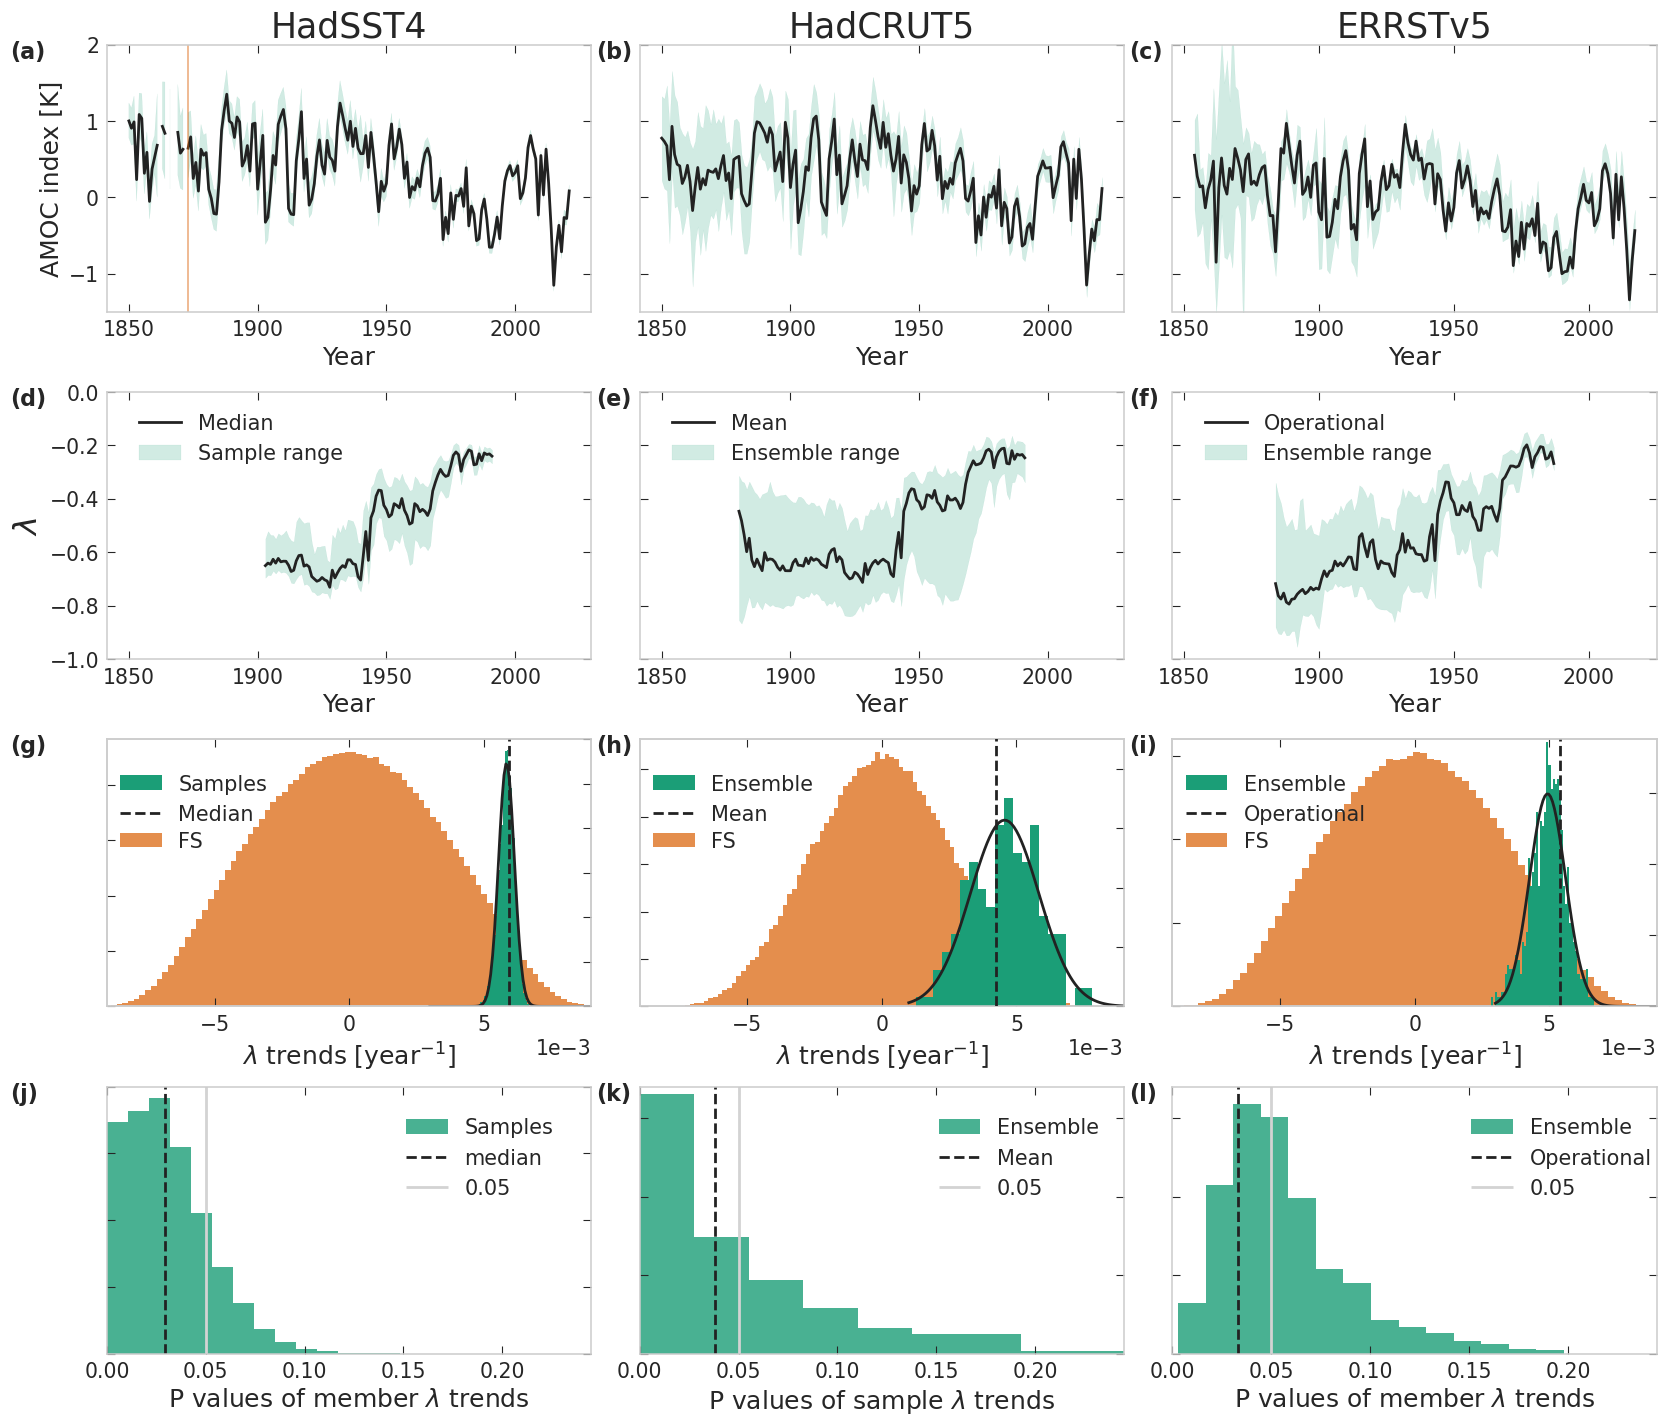

In [61]:
# fig = plt.figure(figsize=(25,23))
fig = plt.figure(figsize=(20,17))
lblsize =18
gs = fig.add_gridspec(nrows=4, ncols=3)

# HadCRUT5 amoc
ax = fig.add_subplot(gs[0,1])
tt = np.arange(1850,2022)
mx = Camocsy.max(dim='member').values
mn = Camocsy.min(dim='member').values
col = 'C0'
plt.plot(tt,Camocy, label='HadSST4 derived Index',lw=2,color='k')
ax.fill_between(tt,mx,mn,alpha=0.2,color='C0',label='Range of sampled time series')
# ax.legend(bbox_to_anchor=(0.05, 0.05), loc='lower left', borderaxespad=0., fontsize=20,fancybox=False,frameon=False)
ax.set_ylim(-1.5,2)
# ax.set_ylabel('AMOC index [K]',fontsize=15)
ax.set_title('HadCRUT5',fontsize=25)
plt.xlabel('Year',fontsize=lblsize)
ax.text(-0.09,0.95,'(b)',transform=ax.transAxes,fontweight='bold')
ax.set_yticklabels([])

# HadSST4 amoc
ax = fig.add_subplot(gs[0,0])
tt = np.arange(1850,2022)
mx = amocsy.max(dim='smps').max(dim='member').values
mn = amocsy.min(dim='smps').min(dim='member').values
col = 'C0'
plt.plot(tt,amocy, label='HadSST4 derived Index',lw=2,color='k')
ax.fill_between(tt,mx,mn,alpha=0.2,color='C0',label='Range of sampled time series')
ax.vlines(1850+23,-3,3,color='C1',alpha=0.5)
# ax.legend(bbox_to_anchor=(0.05, 0.05), loc='lower left', borderaxespad=0., fontsize=20,fancybox=False,frameon=False)
ax.set_ylim(-1.5,2)
ax.set_ylabel('AMOC index [K]',fontsize=lblsize)
ax.set_title('HadSST4',fontsize=25)
plt.xlabel('Year',fontsize=lblsize)
ax.text(-0.2,0.95,'(a)',transform=ax.transAxes,fontweight='bold')

#HadSST4 lambda
ax = fig.add_subplot(gs[1,0],sharex=ax)
tt = np.arange(1873+30,2022-30)
mx = amc_lambdas.max(dim='smps').max(dim='member').values[30:-30]
mn = amc_lambdas.min(dim='smps').min(dim='member').values[30:-30]
col = 'C0'
plt.plot(tt,amc_lam[30:-30], label='Median',lw=2,color='k')
ax.fill_between(tt,mx,mn,alpha=0.2,color='C0',label='Sample range')
ax.legend(bbox_to_anchor=(0.05, 0.7), loc='lower left', borderaxespad=0., fontsize=15,fancybox=False,frameon=False)
ax.set_ylim(-1,0)
ax.set_ylabel('$\lambda$')
plt.xlabel('Year',fontsize=lblsize)
ax.text(-0.2,0.95,'(d)',transform=ax.transAxes,fontweight='bold')

# HadCRUT5 lambda
ax = fig.add_subplot(gs[1,1],sharex=ax)
tt = np.arange(1850+30,2022-30)
mx = Clams.max(dim='member').values[30:-30]
mn = Clams.min(dim='member').values[30:-30]
col = 'C0'
plt.plot(tt,Clam[30:-30], label='Mean',lw=2,color='k')
ax.fill_between(tt,mx,mn,alpha=0.2,color='C0',label='Ensemble range')
ax.legend(bbox_to_anchor=(0.05, 0.7), loc='lower left', borderaxespad=0., fontsize=15,fancybox=False,frameon=False)
ax.set_ylim(-1,0)
# ax.set_ylabel('$\lambda$')
plt.xlabel('Year',fontsize=lblsize)
ax.text(-0.09,0.95,'(e)',transform=ax.transAxes,fontweight='bold')
ax.set_yticklabels([])

# HadSST4 trends
ax = fig.add_subplot(gs[2,0])
plt.hist(smpl_surr_trends.values.ravel(),bins=100,color='C1',density=False,label='FS',alpha=0.7)
ax.legend(bbox_to_anchor=(0.01, 0.55), loc='lower left', borderaxespad=0., fontsize=15,fancybox=False,frameon=False)
ax.set_xlabel("$\lambda$ trends [year$^{-1}$]",fontsize=lblsize)
ax.set_yticklabels([])

ax = ax.twinx()
ax.hist(trends.values.ravel(),bins=50,color='C0',density=True,label='Samples')
ax.set_ylim(0,1500)
ax.vlines(ttrend,0,2000,color='k',linestyle='--',lw=2,label='Median'.format(ttrend,pv))
ax.set_xlabel("$\lambda$ trends [year$^{-1}$]",fontsize=lblsize)
ax.set_title("")
ax.set_yticklabels([])

(mu, sigma) = stats.norm.fit(trends.values.ravel())
 
xx = np.linspace(0.003,0.01,100)
# ax.set_xlim(0.0045,0.007)
ax.plot(xx, stats.norm.pdf(xx, mu, sigma), lw=2,color='k')
#          label='gaussian fit, $\mu$={:.4f} $\sigma$={:.4f}'.format(mu,sigma))
ax.legend(bbox_to_anchor=(0.01, 0.65), loc='lower left', borderaxespad=0., fontsize=15,fancybox=False,frameon=False)
ax.set_yticklabels([])
ax.set_xlim(-0.009,0.009)
ax.text(-0.2,0.95,'(g)',transform=ax.transAxes,fontweight='bold')
ax.ticklabel_format(style='sci', axis='x', scilimits=(0,4))
# HadCRUT5 trends
ax = fig.add_subplot(gs[2,1])
nbins = 20
plt.hist(mem_surr_trends.values.ravel(),bins=100,color='C1',density=False,label='FS',alpha=0.7)
ax.set_xlabel("$\lambda$ trends [year$^{-1}$]",fontsize=lblsize)
ax.legend(bbox_to_anchor=(0.01, 0.55), loc='lower left', borderaxespad=0., fontsize=15,fancybox=False,frameon=False)
ax.set_yticklabels([])

ax = ax.twinx()
ax.hist(Ctrends.values.ravel(),bins=20,color='C0',density=True,label='Ensemble')
ax.set_ylim(0,450)
ax.set_xlabel("$\lambda$ trends [year$^{-1}$]",fontsize=lblsize)
(mu, sigma) = stats.norm.fit(Ctrends.values.ravel())
 
xx = np.linspace(0.001,0.01,100)
ax.set_xlim(-0.009,0.009)
ax.vlines(Cttrend,0,600,color='k',linestyle='--',lw=2,label='Mean'.format(Cttrend,Cpv),zorder=20)
ax.set_xlabel("$\lambda$ trends [year$^{-1}$]",fontsize=lblsize)
ax.plot(xx, stats.norm.pdf(xx, mu, sigma), lw=2,color='k')
#          label='gaussian fit, $\mu$={:.4f} $\sigma$={:.4f}'.format(mu,sigma))
ax.legend(bbox_to_anchor=(0.01, 0.65), loc='lower left', borderaxespad=0., fontsize=15,fancybox=False,frameon=False)
ax.set_yticklabels([])
ax.text(-0.09,0.95,'(h)',transform=ax.transAxes,fontweight='bold')
ax.ticklabel_format(style='sci', axis='x', scilimits=(0,4))
# HadSST4 p values
ax = fig.add_subplot(gs[3,0])
plt.hist(pv_array.pv.values.ravel(),bins=14,density=True,color='C0',alpha=0.8,label='Samples')
ax.vlines(pv,0,40,color='k',linestyle='--',lw=2,label='median')
ax.set_ylim(0,20)
ax.vlines(0.05,0,40,color='lightgrey',linestyle='-',lw=2,label='0.05')
ax.set_xlabel("P values of member $\lambda$ trends",fontsize=lblsize)
ax.legend(bbox_to_anchor=(0.6, 0.55), loc='lower left', borderaxespad=0., fontsize=15,fancybox=False,frameon=False)
ax.set_xlim(0,0.245)
ax.text(-0.2,0.95,'(j)',transform=ax.transAxes,fontweight='bold')
ax.set_yticklabels([])

# HadCRUT5 p values
ax = fig.add_subplot(gs[3,1])
plt.hist(Cpv_array.pv.values.ravel(),bins=10,density=True,color='C0',alpha=0.8,label='Ensemble')
ax.vlines(Cpv,0,20,color='k',linestyle='--',lw=2,label='Mean'.format(Cpv))
ax.vlines(0.05,0,20,color='lightgrey',linestyle='-',lw=2,label='0.05')
ax.text(-0.09,0.95,'(k)',transform=ax.transAxes,fontweight='bold')
ax.set_ylim(0,17)
ax.set_xlabel("P values of sample $\lambda$ trends",fontsize=lblsize)
ax.legend(bbox_to_anchor=(0.6, 0.55), loc='lower left', borderaxespad=0., fontsize=15,fancybox=False,frameon=False)
ax.set_xlim(0,0.245)
ax.set_yticklabels([])


# ERSST amoc
ax = fig.add_subplot(gs[0,2])
tt = np.arange(1854,2018)
mx = (Eamocsy-Eamocsy.mean(dim='time')).max(dim='member').values
mn = (Eamocsy-Eamocsy.mean(dim='time')).min(dim='member').values
col = 'C0'
plt.plot(tt,Eamocy-Eamocy.mean(), label='HadSST4 derived Index',lw=2,color='k')
ax.fill_between(tt,mx,mn,alpha=0.2,color='C0',label='Range of sampled time series')
# ax.legend(bbox_to_anchor=(0.05, 0.05), loc='lower left', borderaxespad=0., fontsize=20,fancybox=False,frameon=False)
ax.set_ylim(-1.5,2)
# ax.set_ylabel('AMOC index [K]',fontsize=lblsize)
plt.xlabel('Year',fontsize=lblsize)
ax.set_title('ERRSTv5',fontsize=25)
# ax.text(-0.15,0.95,'(a)',transform=ax.transAxes,fontweight='bold')
ax.set_yticklabels([])
ax.text(-0.09,0.95,'(c)',transform=ax.transAxes,fontweight='bold')

#ERSST lambda
ax = fig.add_subplot(gs[1,2],sharex=ax)
tt = np.arange(1854+30,2018-30)
mx = Emem_lams.max(dim='member').values[30:-30]
mn = Emem_lams.min(dim='member').values[30:-30]
col = 'C0'
plt.plot(tt,Elam[30:-30], label='Operational',lw=2,color='k')
ax.fill_between(tt,mx,mn,alpha=0.2,color='C0',label='Ensemble range')
ax.legend(bbox_to_anchor=(0.05, 0.7), loc='lower left', borderaxespad=0., fontsize=15,fancybox=False,frameon=False)
ax.set_ylim(-1,0)
# ax.set_ylabel('$\lambda$')
plt.xlabel('Year',fontsize=lblsize)
# ax.text(-0.15,0.95,'(c)',transform=ax.transAxes,fontweight='bold')
ax.set_yticklabels([])
ax.text(-0.09,0.95,'(f)',transform=ax.transAxes,fontweight='bold')



# ERSST trends
ax = fig.add_subplot(gs[2,2])
plt.hist(Emem_surr_trends.values.ravel(),bins=100,color='C1',density=False,label='FS',alpha=0.7)
ax.legend(bbox_to_anchor=(0.01, 0.55), loc='lower left', borderaxespad=0., fontsize=15,fancybox=False,frameon=False)
ax.set_xlabel("$\lambda$ trends [year$^{-1}$]",fontsize=lblsize)
ax.set_yticklabels([])

ax = ax.twinx()
ax.hist(Emem_trends.values.ravel(),bins=50,color='C0',density=True,label='Ensemble')
ax.set_ylim(0,750)
ax.vlines(Ettrend,0,2000,color='k',linestyle='--',lw=2,label='Operational')
ax.set_xlabel("$\lambda$ trends [year$^{-1}$]",fontsize=lblsize)
ax.set_title("")
ax.set_yticklabels([])

(mu, sigma) = stats.norm.fit(Emem_trends.values.ravel())
 
xx = np.linspace(0.003,0.01,100)
# ax.set_xlim(0.0045,0.007)
ax.plot(xx, stats.norm.pdf(xx, mu, sigma), lw=2,color='k')
#          label='gaussian fit, $\mu$={:.4f} $\sigma$={:.4f}'.format(mu,sigma))
ax.legend(bbox_to_anchor=(0.01, 0.65), loc='lower left', borderaxespad=0., fontsize=15,fancybox=False,frameon=False)
ax.set_yticklabels([])
ax.set_xlim(-0.009,0.009)
# ax.text(-0.15,0.95,'(e)',transform=ax.transAxes,fontweight='bold')
ax.text(-0.09,0.95,'(i)',transform=ax.transAxes,fontweight='bold')
ax.ticklabel_format(style='sci', axis='x', scilimits=(0,4))

# ERSST p values
ax = fig.add_subplot(gs[3,2])
plt.hist(Epv_array.pv.values.ravel(),bins=14,density=True,color='C0',alpha=0.8,label='Ensemble')
ax.vlines(Epv,0,40,color='k',linestyle='--',lw=2,label='Operational'.format(Epv))
ax.set_ylim(0,17)
ax.vlines(0.05,0,40,color='lightgrey',linestyle='-',lw=2,label='0.05')
ax.set_xlabel("P values of member $\lambda$ trends",fontsize=lblsize)
ax.legend(bbox_to_anchor=(0.6, 0.55), loc='lower left', borderaxespad=0., fontsize=15,fancybox=False,frameon=False)
ax.set_xlim(0,0.245)
ax.set_yticklabels([])
ax.text(-0.09,0.95,'(l)',transform=ax.transAxes,fontweight='bold')

fig.subplots_adjust(hspace=0.3,wspace=0.1)
fig.savefig('AMOC_uncertainties/plots/indices.png',bbox_inches='tight')
fig.savefig('AMOC_uncertainties/plots/indices.pdf',bbox_inches='tight')
plt.show()

# Ensemble maps

## ERSST data

In [22]:
## because the ensemble is only until 2017, this is the lambdas of the operational data until 2017
Elams17 = xr.open_dataset('/p/tmp/mayayami/sst-uncertainties-data/ERSSTv5/ERSSTv5_lams_w60_rmean.nc').sst[:-5]
Elams17['time']= np.arange(1854,2018)
Elam_trends = Elams17.polyfit(dim = "time", deg = 1).polyfit_coefficients.sel(degree=1)

In [23]:
Eens_trends = xr.open_dataset('/p/tmp/mayayami/sst-uncertainties-data/ERSSTv5/EWS/sst2d.ano.1854.2017.ensemble_full_at2_lams_w60_rmean_trends.nc').polyfit_coefficients.sel(degree=1)
Eens_mus = xr.open_dataset('/p/tmp/mayayami/sst-uncertainties-data/ERSSTv5/EWS/sst2d.ano.1854.2017.ensemble_full_at2_lams_w60_rmean_stats.nc').mu
Eens_sigmas = xr.open_dataset('/p/tmp/mayayami/sst-uncertainties-data/ERSSTv5/EWS/sst2d.ano.1854.2017.ensemble_full_at2_lams_w60_rmean_stats.nc').sigma

## HadCRUT data

In [24]:
Clams = xr.open_dataset('/p/tmp/mayayami/sst-uncertainties-data/HadCRUT/mean_lambdas.nc').lams
Car1s = xr.open_dataset('/p/tmp/mayayami/sst-uncertainties-data/HadCRUT/mean_ar1s.nc').lams
Cstds = xr.open_dataset('/p/tmp/mayayami/sst-uncertainties-data/HadCRUT/mean_stds.nc').lams
Cmean_trends = Clams.polyfit(dim = "year", deg = 1).polyfit_coefficients.sel(degree=1)
Car1s_mean_trends = Car1s.polyfit(dim = "year", deg = 1).polyfit_coefficients.sel(degree=1)
Cstd_mean_trends = Cstds.polyfit(dim = "year", deg = 1).polyfit_coefficients.sel(degree=1)

In [25]:
lam_trends = xr.open_dataset('/p/tmp/mayayami/sst-uncertainties-data/HadCRUT/mean_lambdas_trends.nc').lams_polyfit_coefficients.sel(degree=1)

In [26]:
sampled_mus = xr.open_dataset('/p/tmp/mayayami/sst-uncertainties-data/HadCRUT/sampled/sampled_HadCRUT_w60_runmean_stats.nc').mu
ens_mus = xr.open_dataset('/p/tmp/mayayami/sst-uncertainties-data/HadCRUT/HadCRUT.5.0.1.0.analysis.anomalies_full_w60_runmean_stats.nc').mu
ens_sigmas = xr.open_dataset('/p/tmp/mayayami/sst-uncertainties-data/HadCRUT/HadCRUT.5.0.1.0.analysis.anomalies_full_w60_runmean_stats.nc').sigma

In [27]:
ens_trends = xr.open_dataset('/p/tmp/mayayami/sst-uncertainties-data/HadCRUT/HadCRUT.5.0.1.0.analysis.anomalies_full_w60_runmean_trends.nc').lams_polyfit_coefficients.sel(degree=1)

## plot

In [28]:
## for the calculation of these see example_shift_grid.py
shifted_esig = xr.open_dataset('ens_Csig.nc')
Eshifted_esig = xr.open_dataset('ens_Esig.nc')

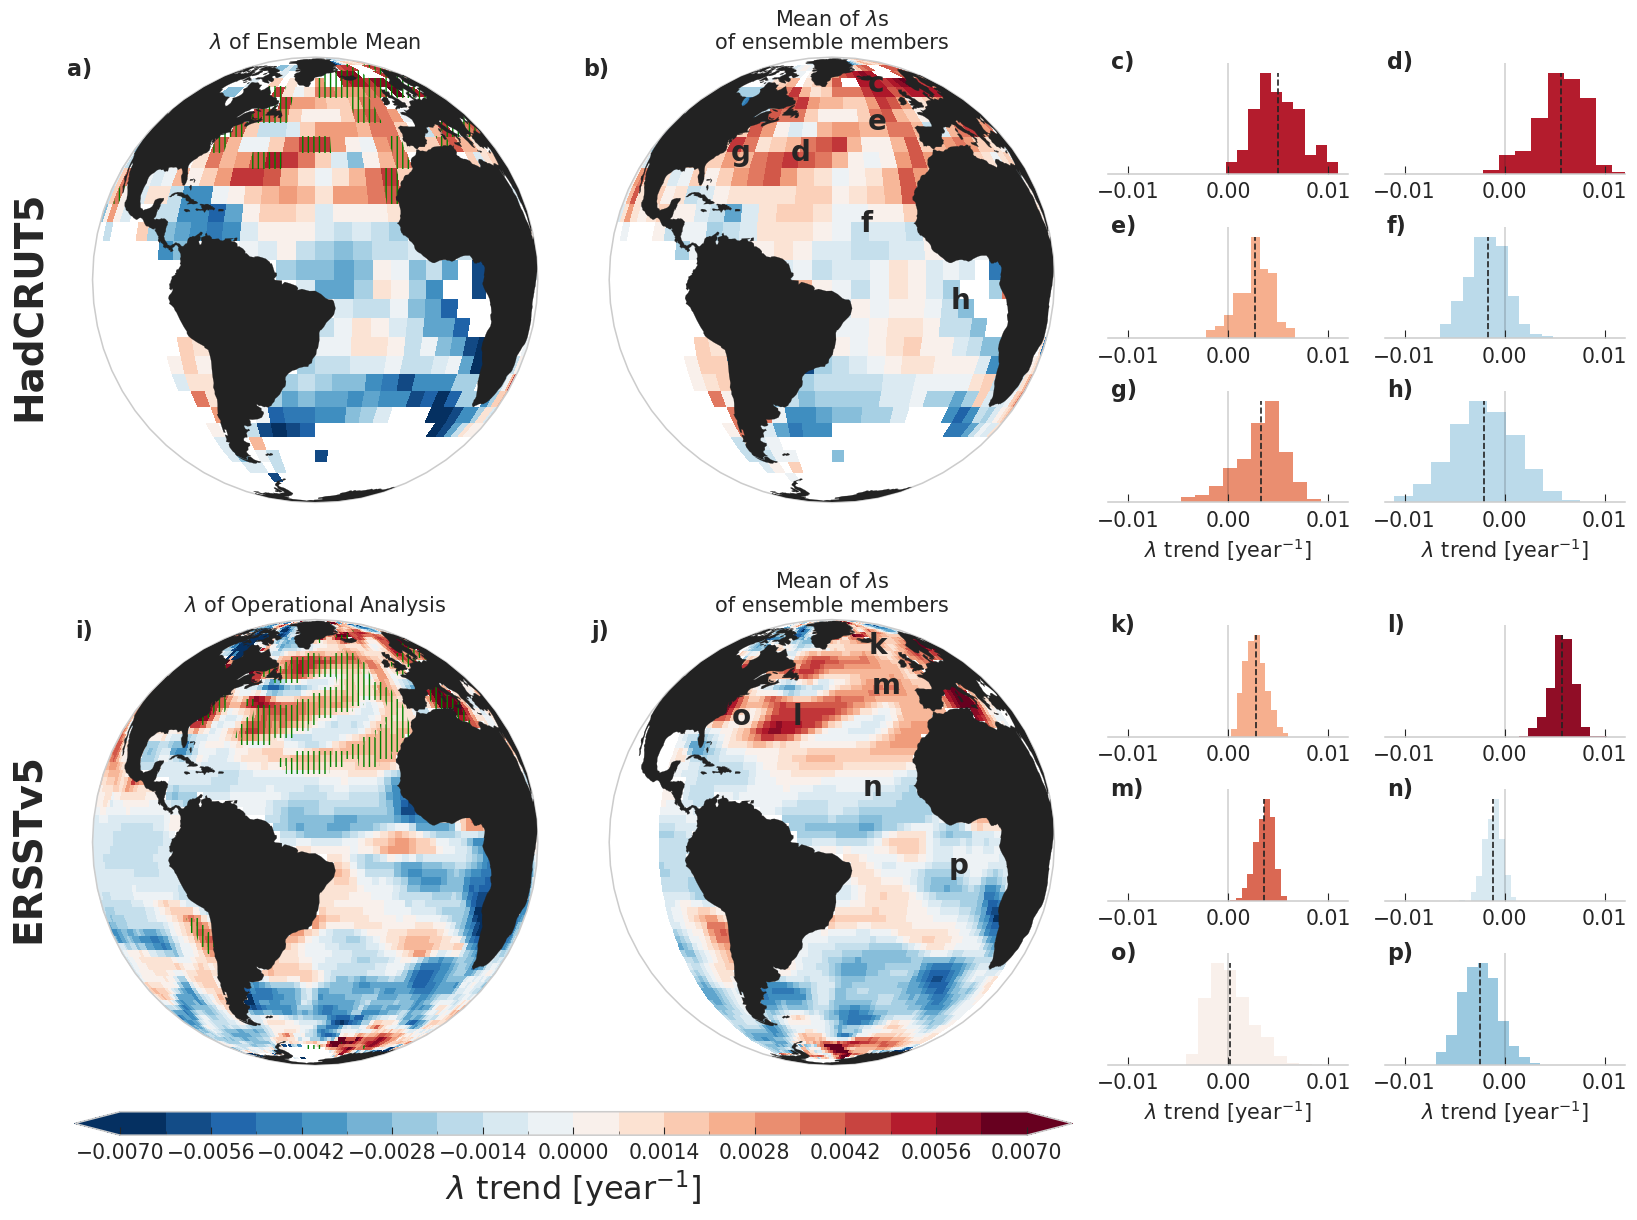

In [29]:
lbls = ['$\lambda$ of Ensemble Mean','Mean of $\lambda$s\nof ensemble members']
levelss = np.linspace(-0.007,0.007,21)
fig = plt.figure(figsize=(20,14))
lblsize =18
mpl.rcParams['hatch.color'] = 'green'
gs = fig.add_gridspec(nrows=8, ncols=4,width_ratios=(1,1,0.5,0.5),height_ratios=(1,1,1,0.2,1,1,1,0.2))
mpl.rcParams['hatch.linewidth'] = 1
cmap = plt.cm.RdBu_r
norm = mpl.colors.BoundaryNorm(levelss, cmap.N)

### HadCRUT

datas = [lam_trends,ens_mus]
for i, data in enumerate(datas):
    ax1 = fig.add_subplot(gs[:3,i], projection=ccrs.Orthographic(central_longitude=320))
    data.plot(
            x = "longitude", 
            y = "latitude",
            ax = ax1,
    #     colors = colorss,
        levels = levelss,
            cmap=plt.cm.RdBu_r,
        add_colorbar=False,
#         cbar_kwargs={"label": "$\lambda$ trend [year$^{-1}$]"},
            transform = ccrs.PlateCarree()
        )
    if i==0:
#         esignificant.plot(levels=[-100,100],colors=['C0','C0'],add_colorbar=False,ax=ax1,transform = ccrs.PlateCarree())
        shifted_esig.pv.plot.contourf(levels = [-100,100],hatches=['|||'],corner_mask=False,colors='none',add_colorbar=False,ax=ax1,transform = ccrs.PlateCarree())
        ax1.text(-0.1,0.7,'HadCRUT5',transform=ax1.transAxes,fontweight='bold', va='top', fontsize=28, ha='right',rotation=90)

    ax1.set_title(lbls[i],fontsize=15)
    ax1.add_feature(cartopy.feature.LAND, edgecolor='black',color='k',zorder=20)
    ax1.text(0,1,labels[i]+')',transform=ax1.transAxes,fontweight='bold', va='top', ha='right')
    ax1.set_global()
lbls = ['$\lambda$ of Operational Analysis','Mean of $\lambda$s\nof ensemble members']
    
datas = [Elam_trends,Eens_mus]
for i, data in enumerate(datas):
    ax2 = fig.add_subplot(gs[4:7,i], projection=ccrs.Orthographic(central_longitude=320))
    data.plot(
            x = "lon", 
            y = "lat",
            ax = ax2,
    #     colors = colorss,
        levels = levelss,
            cmap=plt.cm.RdBu_r,
        add_colorbar=False,
#         cbar_kwargs={"label": "$\lambda$ trend [year$^{-1}$]"},
            transform = ccrs.PlateCarree()
        )
    if i==0:
#         esignificant.plot(levels=[-100,100],colors=['C0','C0'],add_colorbar=False,ax=ax1,transform = ccrs.PlateCarree())
        Eshifted_esig.pv.plot.contourf(levels = [-100,100],hatches=['|||'],
                                       corner_mask=False,colors='none',add_colorbar=False,
                                       ax=ax2,transform = ccrs.PlateCarree())
        ax2.text(-0.1,0.7,'ERSSTv5',transform=ax2.transAxes,fontweight='bold', va='top', fontsize=28, ha='right',rotation=90)
    ax2.set_title(lbls[i],fontsize=15)
    ax2.add_feature(cartopy.feature.LAND, edgecolor='black',color='k',zorder=20)
    ax2.text(0,1,labels[i+8]+')',transform=ax2.transAxes,fontweight='bold', va='top', ha='right')
    ax2.set_global()    
    
coordss = [[[57.5,-22.5],[32.5,-52.5]],[[42.5,-27.5],[12.5,-32.5]],[[32.5,-72.5],[-7.5,-7.5]]]
idc = -1
for i, coords in enumerate(coordss):
    for j, coord in enumerate(coords):
        idc = idc+1
        ax = fig.add_subplot(gs[i,j+2])
        lat, lon = coord[0], coord[1]
        trnds = ens_trends.sel(latitude=lat,longitude=lon)
        mu = ens_mus.sel(latitude=lat,longitude=lon)
        h = ax.hist(trnds,bins=10,color=cmap(norm(mu)),density=True)

        ax.spines.right.set_visible(False)
        ax.spines.top.set_visible(False)
        ax.spines.left.set_visible(False)
        ax.yaxis.set_ticks_position('none')
        ax.xaxis.set_ticks_position('bottom')

        if i==2:
            ax.set_xlabel('$\lambda$ trend [year$^{-1}$]',fontsize=15)
        ax.set_yticklabels([])
        ax.set_xlim(-0.012,0.012)
        ax.text(0.01,0.9,labels[idc+2]+')',transform=ax.transAxes,fontweight='bold')
        ax.vlines(mu,0,h[0].max(),color='k',linestyle='--')
        ax.vlines(0,0,h[0].max()*1.1,color='k',alpha=0.2)
        ax1.text(lon,lat,labels[idc+2],transform = ccrs.PlateCarree(),fontweight='bold',fontsize=20)

coordss = [[[58,-22],[32,-52]],[[42,-26],[12,-32]],[[32,-72],[-8,-8]]]
idc = -1
for i, coords in enumerate(coordss):
    for j, coord in enumerate(coords):
        idc = idc+1
        ax = fig.add_subplot(gs[i+4,j+2])
        lat, lon = coord[0], coord[1]
        trnds = Eens_trends.sel(lat=lat,lon=lon)
        mu = Eens_mus.sel(lat=lat,lon=lon)
        h = ax.hist(trnds,bins=10,color=cmap(norm(mu)),density=True)

        ax.spines.right.set_visible(False)
        ax.spines.top.set_visible(False)
        ax.spines.left.set_visible(False)
        ax.yaxis.set_ticks_position('none')
        ax.xaxis.set_ticks_position('bottom')

        if i==2:
            ax.set_xlabel('$\lambda$ trend [year$^{-1}$]',fontsize=15)
        ax.set_yticklabels([])
        ax.set_xlim(-0.012,0.012)
        ax.text(0.01,0.9,labels[idc+2+8]+')',transform=ax.transAxes,fontweight='bold')
        ax.vlines(mu,0,h[0].max(),color='k',linestyle='--')
        ax.vlines(0,0,h[0].max()*1.1,color='k',alpha=0.2)
        ax2.text(lon,lat,labels[idc+2+8],transform = ccrs.PlateCarree(),fontweight='bold',fontsize=20)

        
cax = fig.add_subplot(gs[7,:2])
cmap = plt.cm.RdBu_r
norm = mpl.colors.BoundaryNorm(levelss, cmap.N)
mpl.colorbar.ColorbarBase(cax, cmap=cmap,ticks=levelss[::2],boundaries=levelss,norm=norm,
                            orientation='horizontal',label='$\lambda$ trend [year$^{-1}$]',extend='both')    
            
        
fig.subplots_adjust(hspace=0.5,wspace=0.1)
fig.savefig('AMOC_uncertainties/plots/HadCRUT.png',bbox_inches='tight')
fig.savefig('AMOC_uncertainties/plots/HadCRUT.pdf',bbox_inches='tight')

plt.show()

# surrogate maps

## HadISST data

In [30]:
Hlams = xr.open_dataset('/p/tmp/mayayami/sst-uncertainties-data/obs_data/HadISST_lambdas_w60_rmean.nc').lams
Hlams['time']=np.arange(1870,2021)
Hmean_trend = Hlams[:,30:-30].polyfit(dim = "time", deg = 1).polyfit_coefficients.sel(degree=1)

In [31]:
ds = xr.open_dataset('/p/tmp/mayayami/sst-uncertainties-data/obs_data/fsurrogates_HadISST_dt50_lams_w60_ndt_100_trends.nc')
trends = ds.lams_polyfit_coefficients.sel(degree=1)
d = Hmean_trend.expand_dims(dim='smps', axis=0)
d['smps']=[100]
trend_arr = xr.concat((trends,d),dim='smps')

trend_pvs = 1- np.apply_along_axis(f, 2, trend_arr)/100
pv_array = xr.Dataset(
        data_vars = dict(pv=(['longitude','latitude'],trend_pvs)),
        coords = dict(
                lat = d.latitude,
        lon = d.longitude))
Hlam_significant = pv_array.pv.where(pv_array.pv<=0.05)

## HadCRUT data

In [32]:
surr_mu = xr.open_dataset('/p/tmp/mayayami/sst-uncertainties-data/HadCRUT/correct_surrogates/HadCRUT_ar2_surrogates_dt20_mv_lambdas_w60_ndt_full_stats.nc').mu
Clambda_trend = xr.open_dataset('/p/tmp/mayayami/sst-uncertainties-data/HadCRUT/mean_lambdas_trends.nc').lams_polyfit_coefficients.sel(degree=1)
ds = xr.open_dataset('/p/tmp/mayayami/sst-uncertainties-data/HadCRUT/correct_surrogates/HadCRUT_ar2_surrogates_dt20_mv_lambdas_w60_ndt_full_trends.nc')
trends = ds.lams_polyfit_coefficients.sel(degree=1)
d = Clambda_trend.transpose().expand_dims(dim='surrogates', axis=0)
d['surrogates']=[1000]
trend_arr = xr.concat((trends,d),dim='surrogates')
trend_pvs = 1- np.apply_along_axis(f, 0, trend_arr)/100
pv_array = xr.Dataset(
        data_vars = dict(pv=(['latitude','longitude'],trend_pvs)),
        coords = dict(
                latitude = d.latitude,
        longitude = d.longitude))
Csignificant = pv_array.pv.where(pv_array.pv<=0.05)


## EN4 data

In [33]:
ds = xr.open_dataset('/p/tmp/mayayami/sst-uncertainties-data/ENS4_analyses/salinity_lambdas_w60_runmean.nc').lambdas
true_lam_trend = ds.polyfit(dim = "time", deg = 1).polyfit_coefficients.sel(degree=1)

ndt05_trends = xr.open_dataset('/p/tmp/mayayami/sst-uncertainties-data/ENS4_analyses/fake_ar2_data2_dt20_elim05_lams_full_w60_ndt_trends.nc').lams_polyfit_coefficients.sel(degree=1)
ndt05_sig = get_significance(true_lam_trend,ndt05_trends,edim='surrogates')

## ERSST data

In [34]:
Elams = xr.open_dataset('/p/tmp/mayayami/sst-uncertainties-data/ERSSTv5/ERSSTv5_lams_w60_rmean_at2.nc').sst
Elams['time']=np.arange(1854,2023)
Emean_trends = Elams.polyfit(dim = "time", deg = 1).polyfit_coefficients.sel(degree=1)

## plots

In [35]:
Csig = xr.open_dataset('Csig.nc').pv
Hsig = xr.open_dataset('Hsig.nc').pv
Ssig = xr.open_dataset('Ssig.nc').pv
Esig = xr.open_dataset('Esig.nc').pv

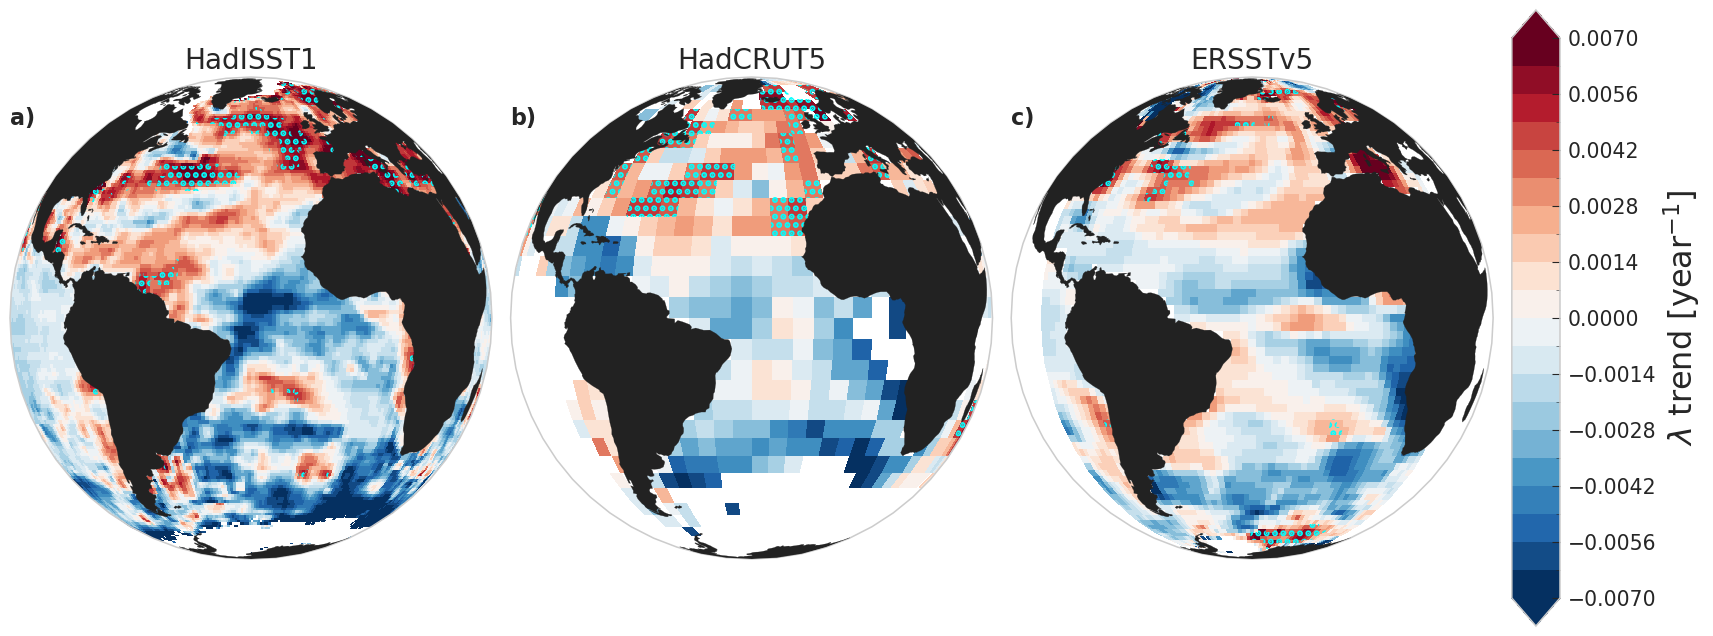

In [36]:
fig = plt.figure(figsize=(20,8))
colorss = ['#67001f','#b2182b','#d6604d','#f4a582','#fddbc7','#f7f7f7','#d1e5f0','#92c5de','#4393c3','#2166ac'][::-1]
levelss = np.linspace(-0.007,0.007,21)
mpl.rcParams['hatch.color'] = 'cyan'
mpl.rcParams['hatch.linewidth'] = 3

gs = fig.add_gridspec(nrows=1, ncols=4,width_ratios=(1,1,1,0.1))

ax = fig.add_subplot(gs[0,0], projection=ccrs.Orthographic(central_longitude=330))
Hmean_trend.plot(
    x = "longitude", 
    y = "latitude",
    ax = ax,
    levels=levelss,
cmap =  plt.cm.RdBu_r,
                         add_colorbar=False,
    transform = ccrs.PlateCarree()
)

Hsig.plot.contourf(levels = [-100,100], x = "longitude",  corner_mask=False, y = "latitude",hatches=['..'],colors='none',add_colorbar=False,ax=ax,transform = ccrs.PlateCarree())
ax.set_global()
ax.set_title('HadISST1',fontsize=20)
ax.add_feature(cartopy.feature.LAND, edgecolor='black',color='k',zorder=20)
ax.text(0,0.9,'a)',transform=ax.transAxes,fontweight='bold')

ax = fig.add_subplot(gs[0,1], projection=ccrs.Orthographic(central_longitude=330))
Clambda_trend.plot(
    x = "longitude", 
    y = "latitude",
    ax = ax,
    levels=levelss,
cmap =  plt.cm.RdBu_r,
                         add_colorbar=False,
    transform = ccrs.PlateCarree()
)

Csig.plot.contourf(levels = [-100,100],hatches=['..'],corner_mask=False,colors='none',add_colorbar=False,ax=ax,transform = ccrs.PlateCarree())
ax.set_global()
ax.set_title('HadCRUT5',fontsize=20)
ax.add_feature(cartopy.feature.LAND, edgecolor='black',color='k',zorder=20)
ax.text(0,0.9,'b)',transform=ax.transAxes,fontweight='bold')

ax = fig.add_subplot(gs[0,2], projection=ccrs.Orthographic(central_longitude=330))
Emean_trends.plot(
    x = "lon", 
    y = "lat",
    ax = ax,
    levels=levelss,
cmap =  plt.cm.RdBu_r,
                         add_colorbar=False,
    transform = ccrs.PlateCarree()
)

Esig.plot.contourf(levels = [-100,100],hatches=['..'],corner_mask=False,colors='none',add_colorbar=False,ax=ax,transform = ccrs.PlateCarree())
ax.set_global()
ax.set_title('ERSSTv5',fontsize=20)
ax.add_feature(cartopy.feature.LAND, edgecolor='black',color='k',zorder=20)
ax.text(0,0.9,'c)',transform=ax.transAxes,fontweight='bold')

      

cax = fig.add_subplot(gs[0,3])
cmap = plt.cm.RdBu_r
norm = mpl.colors.BoundaryNorm(levelss, cmap.N)
mpl.colorbar.ColorbarBase(cax, cmap=cmap,ticks=levelss[::2],boundaries=levelss,norm=norm,
                            orientation='vertical',label='$\lambda$ trend [year$^{-1}$]',extend='both')
fig.subplots_adjust(hspace=0.05,wspace=0.05)
fig.savefig('AMOC_uncertainties/plots/SST_significance.png',bbox_inches='tight')
fig.savefig('AMOC_uncertainties/plots/SST_significance.pdf',bbox_inches='tight')
plt.show()

In [37]:
dmeany_wei = xr.open_dataset('/p/tmp/mayayami/sst-uncertainties-data/ENS4_analyses/weights_dmean_ymean_at.nc').salinity_observation_weights.squeeze()[:-1]
y005 = abs(np.sign(dmeany_wei.where(dmeany_wei>=0.05))).sum(dim='time')
y05 = abs(np.sign(dmeany_wei.where(dmeany_wei>=0.5))).sum(dim='time')
y03 = abs(np.sign(dmeany_wei.where(dmeany_wei>=0.3))).sum(dim='time')

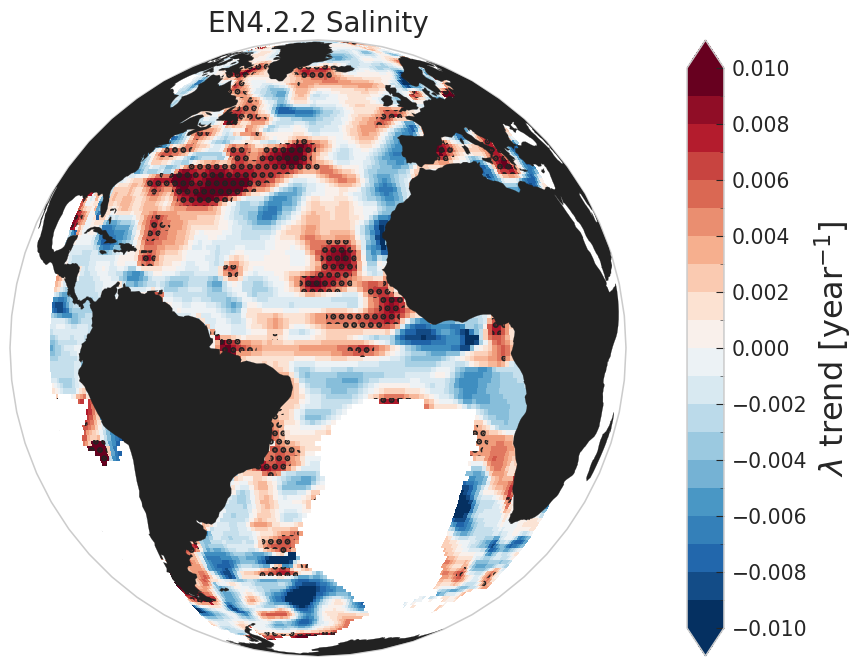

In [38]:
fig = plt.figure(figsize=(10,8))
colorss = ['#67001f','#b2182b','#d6604d','#f4a582','#fddbc7','#f7f7f7','#d1e5f0','#92c5de','#4393c3','#2166ac'][::-1]
levelss = np.linspace(-0.01,0.01,21)
mpl.rcParams['hatch.color'] = 'k'
mpl.rcParams['hatch.linewidth'] = 3

gs = fig.add_gridspec(nrows=1, ncols=2,width_ratios=(1,0.05))


ax = fig.add_subplot(gs[0,0], projection=ccrs.Orthographic(central_longitude=330))
true_lam_trend.where(y005>=60).plot(
    x = "lon", 
    y = "lat",
    ax = ax,
    levels=levelss,
cmap =  plt.cm.RdBu_r,
                         add_colorbar=False,
    transform = ccrs.PlateCarree()
)

Ssig.plot.contourf(x='lon',y='lat',levels = [-100,100],corner_mask=False,hatches=['..'],colors='none',add_colorbar=False,ax=ax,transform = ccrs.PlateCarree())
y005.where(y005<=60).plot(ax=ax,levels=[-100,100],colors=['white','white'],add_colorbar=False,transform=ccrs.PlateCarree())
ax.set_global()
ax.set_title('EN4.2.2 Salinity',fontsize=20)
ax.add_feature(cartopy.feature.LAND, edgecolor='black',color='k',zorder=20)


cax = fig.add_subplot(gs[0,1])
cmap = plt.cm.RdBu_r
norm = mpl.colors.BoundaryNorm(levelss, cmap.N)
mpl.colorbar.ColorbarBase(cax, cmap=cmap,ticks=levelss[::2],boundaries=levelss,norm=norm,
                            orientation='vertical',label='$\lambda$ trend [year$^{-1}$]',extend='both')
fig.subplots_adjust(hspace=0.05,wspace=0)
fig.savefig('AMOC_uncertainties/plots/salinity_significance.png',bbox_inches='tight')
plt.show()

# number of observations

In [39]:
SST = xr.open_dataset('/p/tmp/mayayami/sst-uncertainties-data/obs_data/HadCRUT.5.0.1.0.analysis.anomalies.ensemble_mean_SST.nc').tas_mean


In [40]:
nobs = xr.open_dataset('/p/tmp/mayayami/sst-uncertainties-data/uncertainties/HadSST.4.0.1.0_number_of_observations.nc').numobs
nsuperobs = xr.open_dataset('/p/tmp/mayayami/sst-uncertainties-data/uncertainties/HadSST.4.0.1.0_number_of_superobservations.nc').numsuperobs

In [41]:
def get_spg(data):
    lat_max = 61
    lat_min = 46
    lon_max = -20
    lon_min = -55

    spg_full = (
            data
            .where(data['longitude'] >= lon_min,drop=True)
            .where(data['longitude'] <= lon_max,drop=True)
            .where(data['latitude'] >= lat_min,drop=True)
            .where(data['latitude'] <= lat_max,drop=True)
        )

    return spg_full

In [42]:
nobs_spg = get_spg(nobs).sum(dim=['latitude','longitude'])
nsuperobs_spg = get_spg(nsuperobs).sum(dim=['latitude','longitude'])
nobs_gl = nobs.sum(dim=['latitude','longitude'])
nsuperobs_gl = nsuperobs.sum(dim=['latitude','longitude'])

In [43]:
mediany = xr.open_dataarray('/p/tmp/mayayami/sst-uncertainties-data/HadSST/HadSST.4.0.1.0_median_ymean.nc')
sy = mediany.copy()
sy = abs(np.sign(sy))
ndata_spg = get_spg(sy).sum(dim=['latitude','longitude'])
ndata_gl = sy.sum(dim=['latitude','longitude'])

In [44]:
ndata_spg_p = ndata_spg/(3*7)
ndata_gl_p = ndata_gl/(36*72)

In [45]:
Cmedian = xr.open_dataset('/p/tmp/mayayami/sst-uncertainties-data/obs_data/HadCRUT.5.0.1.0.analysis.anomalies.ensemble_mean.nc').tas_mean
Cmediany = yearly_avg(Cmedian)
Csy = Cmediany.copy()
Csy = abs(np.sign(Csy))

Cmedian_SST = xr.open_dataset('/p/tmp/mayayami/sst-uncertainties-data/obs_data/HadCRUT.5.0.1.0.analysis.anomalies.ensemble_mean_SST.nc').tas_mean
Cmediany_SST = yearly_avg(Cmedian_SST)
Cndata_spg = get_spg(Csy).sum(dim=['latitude','longitude'])
Cndata_gl = Csy.sum(dim=['latitude','longitude'])

In [46]:
Cndata_spg_p = Cndata_spg/(3*7)
Cndata_gl_p = Cndata_gl/(36*72)

In [47]:
def add_box(ax,sqr,col='k'):
    min_lat, min_lon, max_lat, max_lon = sqr[0], sqr[1],sqr[2], sqr[3]
    latsq = [min_lat, max_lat, max_lat, min_lat]
    lonsq = [min_lon, min_lon, max_lon, max_lon]
    ring = LinearRing(list(zip(lonsq, latsq)))
    ax.add_geometries([ring], ccrs.PlateCarree(), facecolor='None', edgecolor=col,linewidth=5)

/tmp/ipykernel_11982/3480518133.py:54: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap('YlOrBr'),
/tmp/ipykernel_11982/3480518133.py:96: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap('YlOrBr'),


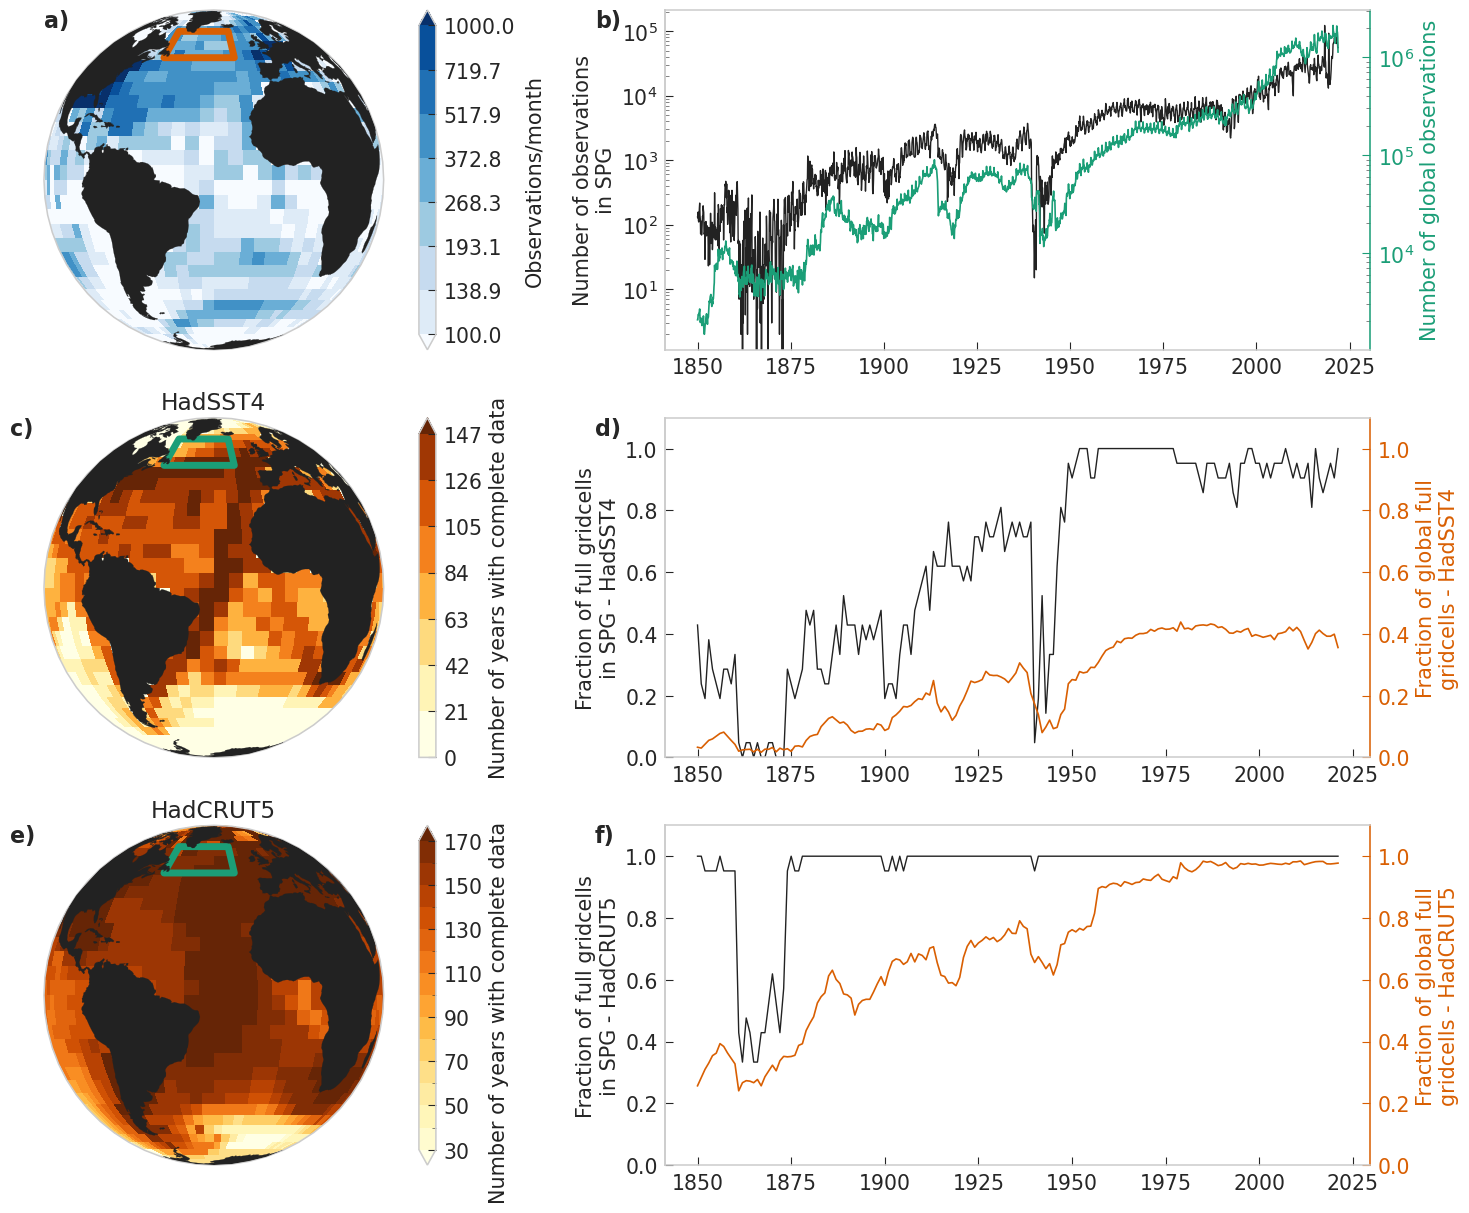

In [48]:
fig = plt.figure(figsize=(20,15))
lblsize =18
gs = fig.add_gridspec(nrows=3, ncols=2)

# nobs
ax = fig.add_subplot(gs[0,0], projection=ccrs.Orthographic(central_longitude=330))
levelss = np.logspace(2,3,8)
nobs.mean(dim='time').plot(
        x = "longitude", 
        y = "latitude",
        ax = ax,
    levels = levelss,
    cmap =  plt.cm.Blues,
    cbar_kwargs={"label": ""},
        transform = ccrs.PlateCarree()
    )
ax.add_feature(cartopy.feature.LAND, edgecolor='black',color='k',zorder=20)
# ax.set_title('')
add_box(ax,[46,-55,61,-20],col='C1')
ax.text(0,0.95,'a)',transform=ax.transAxes,fontweight='bold')

ax = fig.add_subplot(gs[0,1])
ax.plot(nobs_spg.values[:-7],color='k',lw=1)
ax.set_ylabel('Number of observations\nin SPG',fontsize=15,zorder=20)
# ax.set_xlabel('Time',fontsize=15)
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.spines.bottom.set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.set_xticks(np.arange(0,200,25)*12)
ax.set_xticklabels(np.arange(1850,2050,25))# ax.set_ylim(0,1)
ax.set_yscale('log')
ax.text(-0.1,0.95,'b)',transform=ax.transAxes,fontweight='bold')

ax2 = ax.twinx()
ax2.plot(nobs_gl.values[:-7],color='C0')
ax2.set_ylabel('Number of global observations',fontsize=15)
# ax2.set_ylim(0,den_reg.max())
ax2.spines["right"].set_edgecolor('C0')
ax2.yaxis.label.set_color('C0')
ax2.tick_params(axis='y', colors='C0')
ax2.set_yscale('log')


# HadSST4 gridcells
ax=fig.add_subplot(gs[1,0], projection=ccrs.Orthographic(central_longitude=330))
levelss = np.arange(0,160,21)
sy.sum(dim='year').plot(
        x = "longitude", 
        y = "latitude",
        ax = ax,
    levels = levelss,
    cmap = mpl.cm.get_cmap('YlOrBr'),
#     cbar_kwargs={"label": "Number of years\nwith complete data"},
        transform = ccrs.PlateCarree()
    )
ax.add_feature(cartopy.feature.LAND, edgecolor='black',color='k',zorder=20)
ax.set_title('HadSST4')
add_box(ax,[46,-55,61,-20],col='C0')
ax.text(-0.1,0.95,'c)',transform=ax.transAxes,fontweight='bold')

ax = fig.add_subplot(gs[1,1])
ax.plot(np.arange(1850,2022),ndata_spg_p.values[:-1],color='k',lw=1)
ax.set_ylabel('Fraction of full gridcells\nin SPG - HadSST4',fontsize=15,zorder=20)
# ax.set_xlabel('Time',fontsize=15)
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.spines.bottom.set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
# ax.set_xticklabels(np.arange(1850,2022))
# ax.set_ylim(0,1)
# ax.set_yscale('log')
ax.text(-0.1,0.95,'d)',transform=ax.transAxes,fontweight='bold')
ax.set_ylim(0,1.1)

ax2 = ax.twinx()
ax2.plot(np.arange(1850,2022),ndata_gl_p.values[:-1],color='C1')
ax2.set_ylabel('Fraction of global full\ngridcells - HadSST4',fontsize=15)
# ax2.set_ylim(0,den_reg.max())
ax2.spines["right"].set_edgecolor('C1')
ax2.yaxis.label.set_color('C1')
ax2.tick_params(axis='y', colors='C1')
# ax2.set_yscale('log')
ax2.set_ylim(0,1.1)

# HadCRUT5 gridcells
ax=fig.add_subplot(gs[2,0], projection=ccrs.Orthographic(central_longitude=330))
levelss = np.arange(30,175,10)
Csy.sum(dim='year').plot(
        x = "longitude", 
        y = "latitude",
        ax = ax,
    levels = levelss,
    cmap = mpl.cm.get_cmap('YlOrBr'),
#     cbar_kwargs={"label": "Number of years\nwith complete data"},
        transform = ccrs.PlateCarree()
    )

ax.add_feature(cartopy.feature.LAND, edgecolor='black',color='k',zorder=20)
ax.set_title('HadCRUT5')
add_box(ax,[46,-55,61,-20],col='C0')
ax.text(-0.1,0.95,'e)',transform=ax.transAxes,fontweight='bold')

ax = fig.add_subplot(gs[2,1])
ax.plot(np.arange(1850,2022),Cndata_spg_p.values[:-1],color='k',lw=1)
ax.set_ylabel('Fraction of full gridcells\nin SPG - HadCRUT5',fontsize=15,zorder=20)
# ax.set_xlabel('Time',fontsize=15)
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.spines.bottom.set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
# ax.set_xticklabels()
ax.set_ylim(0,1.1)
# ax.hlines()
# ax.set_yscale('log')
ax.text(-0.1,0.95,'f)',transform=ax.transAxes,fontweight='bold')

ax2 = ax.twinx()
ax2.plot(np.arange(1850,2022),Cndata_gl_p.values[:-1],color='C1')
ax2.set_ylabel('Fraction of global full\ngridcells - HadCRUT5',fontsize=15)
# ax2.set_ylim(0,den_reg.max())
ax2.spines["right"].set_edgecolor('C1')
ax2.yaxis.label.set_color('C1')
ax2.tick_params(axis='y', colors='C1')
ax2.set_ylim(0,1.1)


ax2.text(-0.2,2.6,'Observations/month',transform=ax.transAxes,color='k',fontsize=15,rotation=90)
ax2.text(-0.25,1.15,'Number of years with complete data',transform=ax.transAxes,color='k',fontsize=15,rotation=90)
ax2.text(-0.25,-0.1,'Number of years with complete data',transform=ax.transAxes,color='k',fontsize=15,rotation=90)


# ax2.set_yscale('log')
fig.savefig('AMOC_uncertainties/plots/nobs.png',bbox_inches='tight')
fig.savefig('AMOC_uncertainties/plots/nobs.pdf',bbox_inches='tight')

plt.show()

# significance regions

In [49]:
Esig = xr.open_dataset('Esig.nc').pv

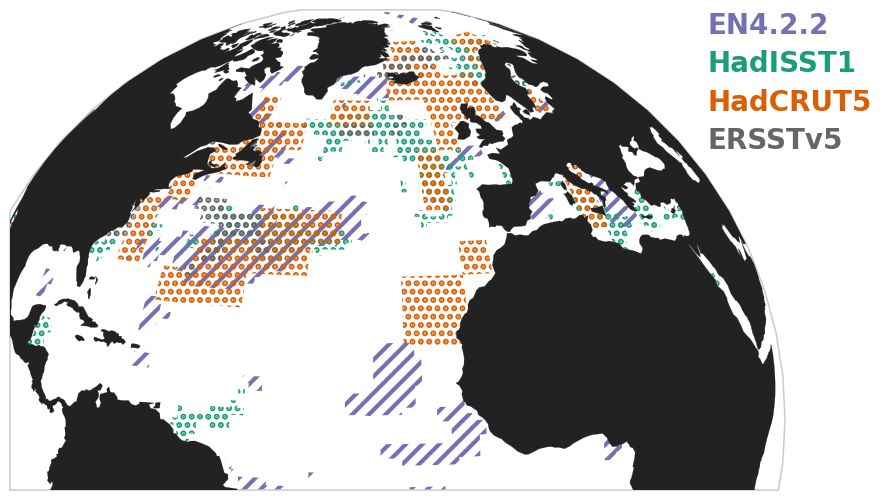

In [50]:
fig = plt.figure(figsize=(10,13))
levelss = np.linspace(-0.01,0.01,21)
mpl.rcParams['hatch.linewidth'] = 3


ax = fig.add_subplot(111, projection=ccrs.Orthographic(central_longitude=330,central_latitude=10))
levelss = np.linspace(0,0.4,21)


mpl.rcParams['hatch.color'] = 'C2'
Ssig.plot.contourf(levels = [-100,100],hatches=['//'],colors='none',corner_mask=False,add_colorbar=False,ax=ax,transform = ccrs.PlateCarree())
mpl.rcParams['hatch.color'] = 'C0'
Hsig.plot.contourf(levels = [-100,100],
                                   x = "longitude", 
                            y = "latitude",corner_mask=False,
                               hatches=['..'],colors='none',add_colorbar=False,ax=ax,transform = ccrs.PlateCarree())
mpl.rcParams['hatch.color'] = 'C1'
Csig.plot.contourf(levels = [-100,100],
                                   x = "longitude", 
                            y = "latitude",
                               hatches=['..'],colors='none',corner_mask=False,add_colorbar=False,ax=ax,transform = ccrs.PlateCarree())
mpl.rcParams['hatch.color'] = 'C7'
Esig.plot.contourf(levels = [-100,100],
                                   x = "lon", 
                            y = "lat",
                               hatches=['..'],colors='none',corner_mask=False,add_colorbar=False,ax=ax,transform = ccrs.PlateCarree())
 
ax.text(0.9,0.95,'EN4.2.2',transform=ax.transAxes,fontweight='bold',color='C2',fontsize=20)
ax.text(0.9,0.87,'HadISST1',transform=ax.transAxes,fontweight='bold',color='C0',fontsize=20)
ax.text(0.9,0.79,'HadCRUT5',transform=ax.transAxes,fontweight='bold',color='C1',fontsize=20)
ax.text(0.9,0.71,'ERSSTv5',transform=ax.transAxes,fontweight='bold',color='C7',fontsize=20)

ax.set_global()
ax.add_feature(cartopy.feature.LAND, edgecolor='black',color='k',zorder=20)
ax.set_title('')
ax.set_extent([-90, 90,0,90], crs=ccrs.PlateCarree())
fig.savefig('AMOC_uncertainties/plots/sig_regions.png',bbox_inches='tight')
fig.savefig('AMOC_uncertainties/plots/sig_regions.pdf',bbox_inches='tight')
# fig.suptitle('Regions of significant $\lambda$ increase in the North Atlantic',fontsize=25,y=0.79)
plt.show()